# Setup

### Library Import

In [5]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

#### Data Import

In [81]:
# Load data from data folder
df = pd.read_csv('../data/sample_xlarge.csv')

In [82]:
figure = lambda r=1, c=1, w=12, h=6: plt.subplots(r, c, figsize=(w, h))

# Describe

In [ ]:
len(df)

In [83]:
df[df.user_id == 1444111]

,classified_id,listed_at_date,product_id,user_id,classified_price,retail_price,listing_price,favourites,viewed_count,state,brand_name,condition_name,size_name,color_name,subcategory_name,category_name
493730,28103417,2023-05-07,2738819,1444111,100,NaN,100.0,5,39,10,Newline Halo,Good but used,Size XL,Petroleum,T-shirts,Men
525459,28042316,2023-05-03,3993302,1444111,575,1500.0,600.0,9,213,10,Gramicci,Good but used,Size XL,Black,Jackets,Men
574349,28041007,2023-05-03,3993052,1444111,375,800.0,400.0,3,45,10,Carhartt WIP,Good but used,W36/L34,Navy,Trousers,Men
810368,26217642,2023-01-11,3652834,1444111,700,NaN,850.0,0,241,5,New Balance,Good but used,Size 45,Army green,Shoes,Men
893372,28041582,2023-05-03,1629439,1444111,80,NaN,100.0,5,74,10,Axel Arigato,Good but used,Size L,Black,T-shirts,Men
935285,28042277,2023-05-03,1629439,1444111,90,NaN,100.0,11,150,10,Axel Arigato,Good but used,Size L,Black,T-shirts,Men
1036603,28041392,2023-05-03,2674235,1444111,180,1500.0,200.0,12,74,10,Axel Arigato,Good but used,Size XL,Black,Knitwear,Men
1148040,28041372,2023-05-03,663548,1444111,200,NaN,200.0,0,6,10,Stone Island,Shabby,Size XL,Black,Hoodies,Men
1470804,31184466,2023-10-17,4543296,1444111,200,500.0,250.0,6,100,10,Gramicci,Never used,Size XL,White,T-shirts,Men


In [84]:
df[df.brand_name == 'Gramicci']

,classified_id,listed_at_date,product_id,user_id,classified_price,retail_price,listing_price,favourites,viewed_count,state,brand_name,condition_name,size_name,color_name,subcategory_name,category_name
449569,30866211,2023-10-02,3481045,1946219,365,950.0,365.0,6,21,10,Gramicci,"New, still with price",Size M,Beige,Trousers,Men
462010,25875186,2022-12-13,2755294,1506199,449,900.0,449.0,3,43,10,Gramicci,Almost as new,Size L,Brown,Trousers,Men
464137,31295884,2023-10-22,2103061,1951969,650,1500.0,750.0,31,439,10,Gramicci,Almost as new,Size M,Black,Trousers,Men
464613,28579486,2023-06-04,3861260,1390661,150,NaN,150.0,3,23,10,Gramicci,Almost as new,Size M,Black,Shorts,Men
467828,27346784,2023-03-23,3866373,1804862,179,NaN,179.0,16,132,10,Gramicci,Good but used,Size L,Purple,Shorts,Men
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574990,29277929,2023-07-16,4213180,1956241,550,NaN,600.0,8,59,10,Gramicci,Almost as new,Size L,Beige,Trousers,Men
1576716,28628106,2023-06-06,3127771,2226013,800,1050.0,850.0,0,224,5,Gramicci,Never used,Size S,Navy,Trousers,Men
1578835,30440646,2023-09-12,4415114,2230702,400,800.0,400.0,2,29,10,Gramicci,Never used,Size M,Olive,Trousers,Men
1582398,30587030,2023-09-19,4440132,2216165,320,NaN,320.0,1,51,10,Gramicci,Good but used,W32,White,Trousers,Men


In [68]:
def describe(df :pd.DataFrame):
    columns = df.columns
    dtpyes = df.dtypes
    nulls = df.isnull().sum()
    unique = df.nunique()
    maxs = df.max()
    mins = df.min()
    std = df.std()
    #percentiles = df.quantile([.25, .5, .75, .9, .95])
    
    return pd.DataFrame({'columns': columns, 
                         'dtpyes': dtpyes, 
                         'nulls': nulls, 
                         'unique': unique,
                         'max': maxs,
                         'min': mins,
                         'std': std})

# Data Exploration

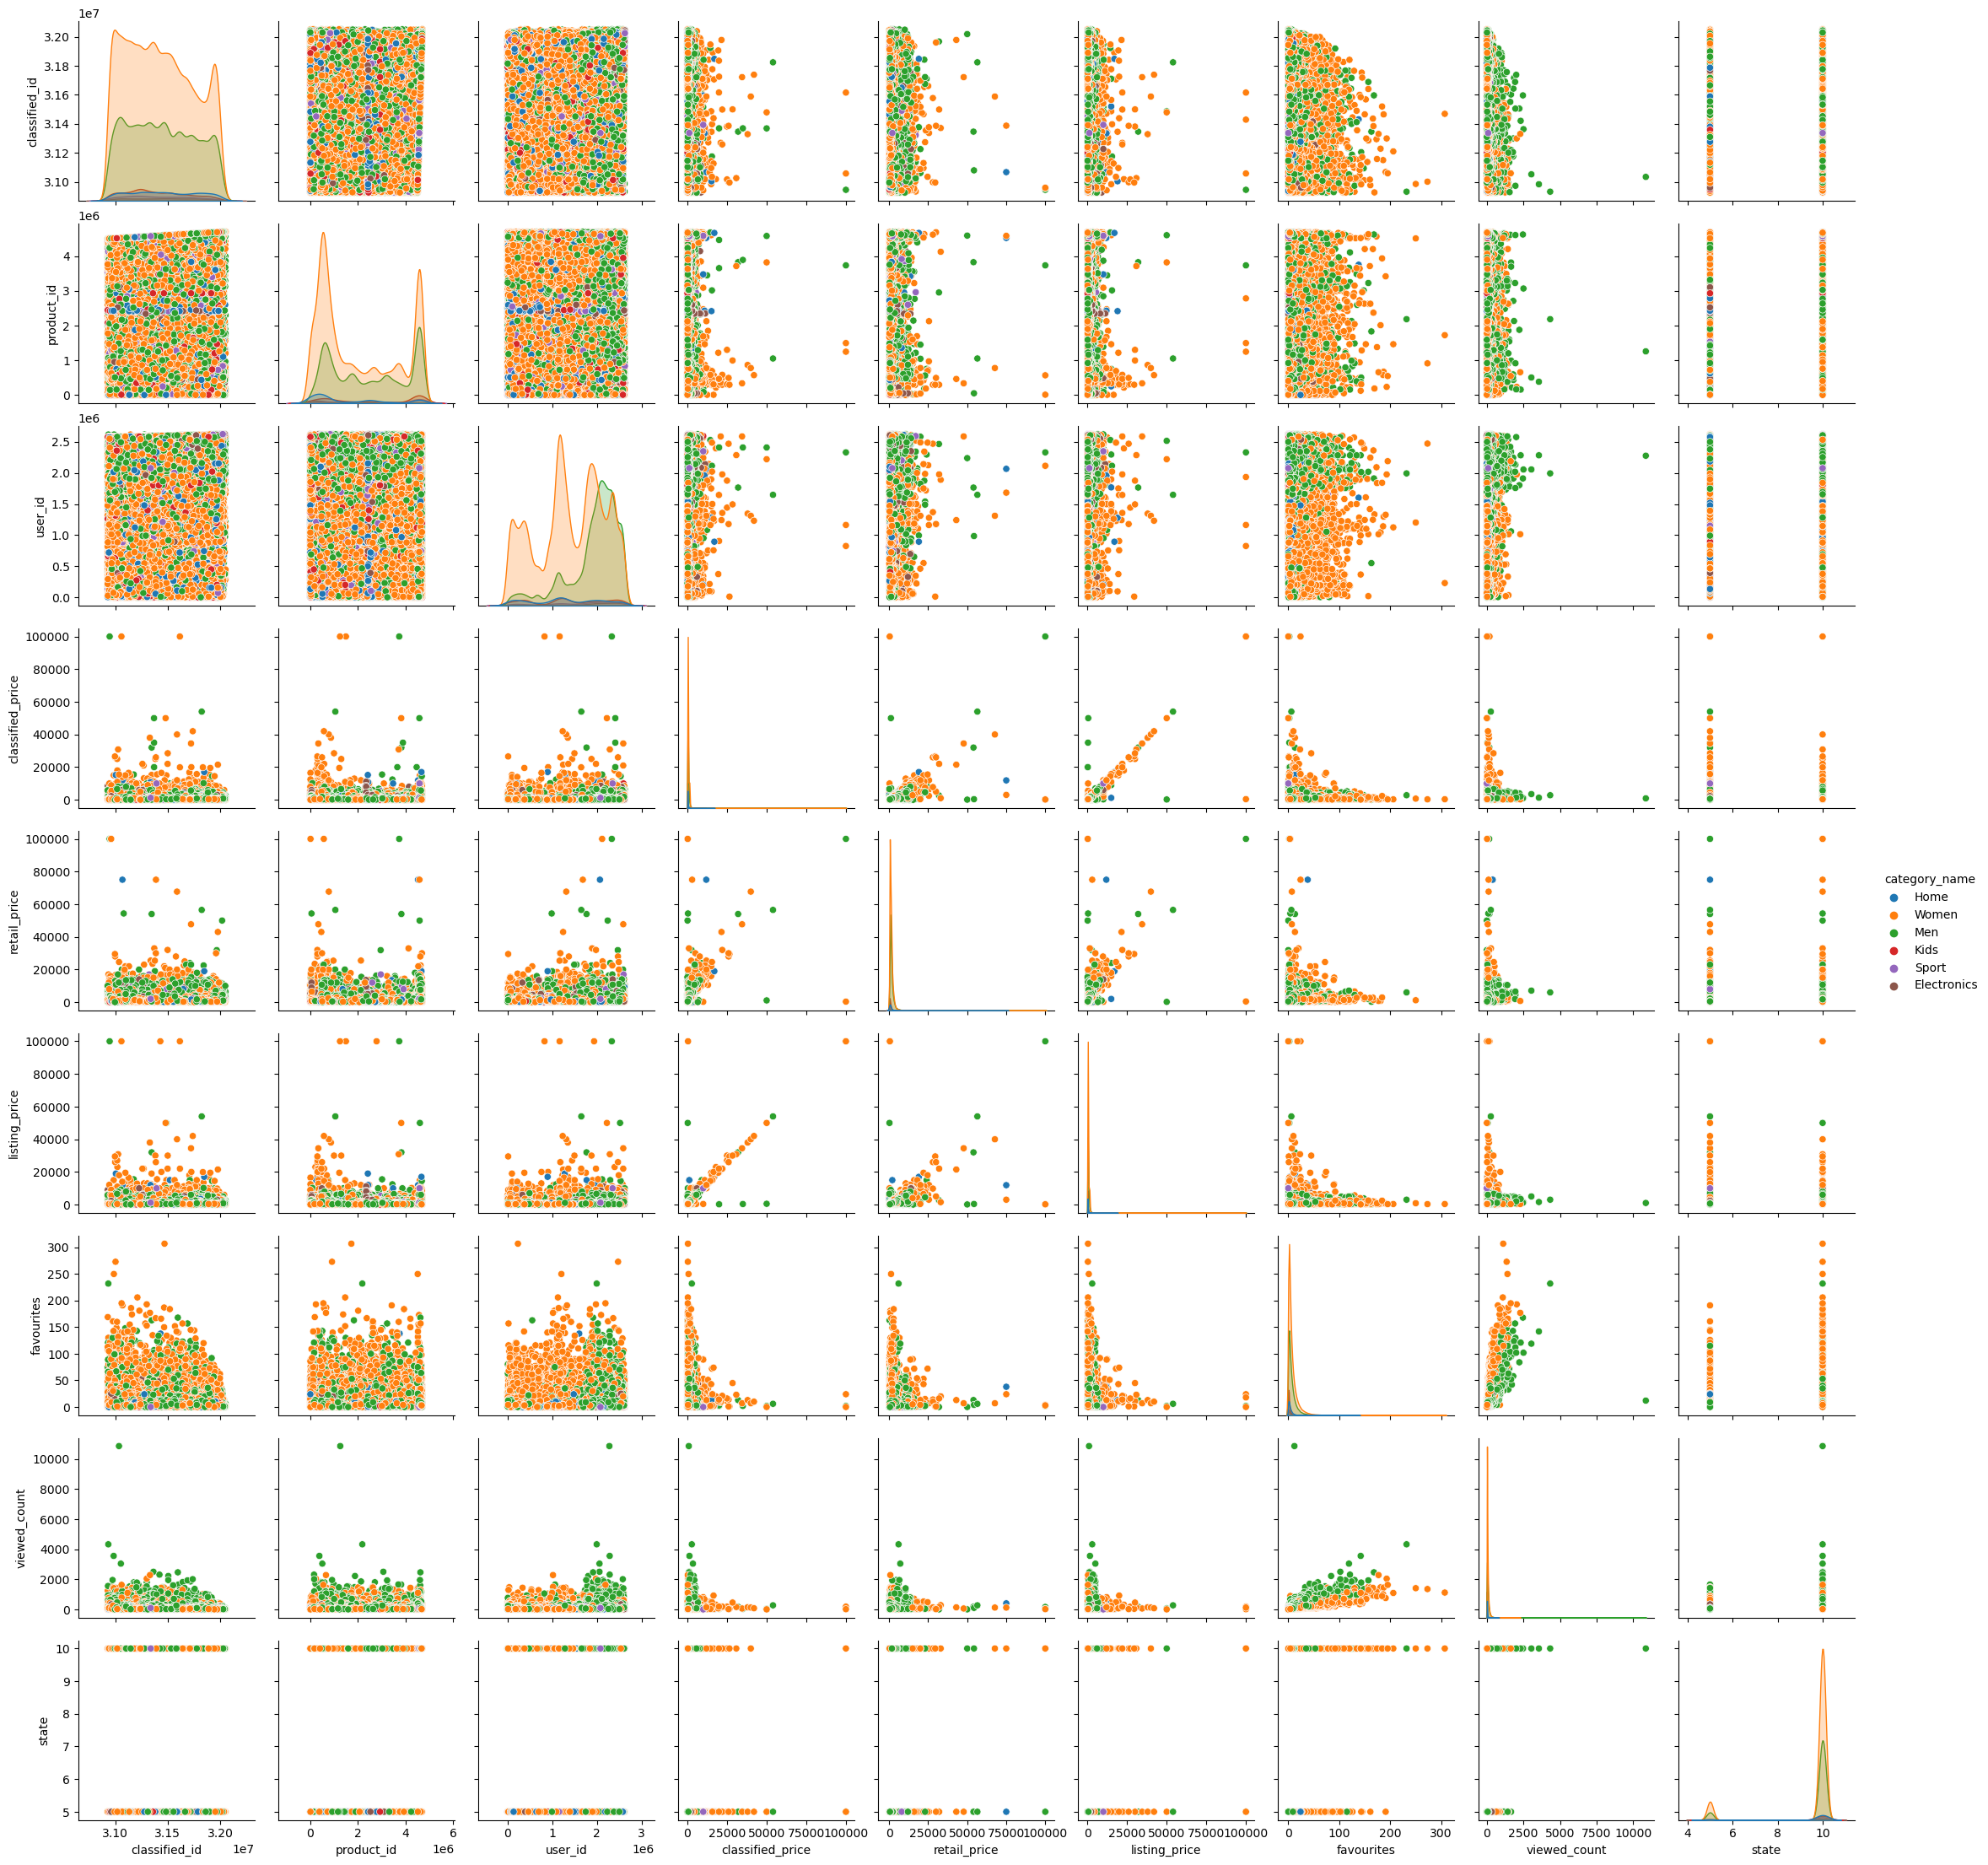

In [28]:
sns.pairplot(df, hue='category_name')

In [42]:
# Columns and data types
df.dtypes

classified_id         int64
listed_at_date       object
product_id            int64
user_id               int64
classified_price      int64
retail_price        float64
listing_price         int64
favourites            int64
viewed_count          int64
state                 int64
brand_name           object
condition_name       object
size_name            object
color_name           object
subcategory_name     object
category_name        object
dtype: object

In [33]:
# Columns and data types
df.isna().sum()

classified_id            0
listed_at_date           0
product_id               0
user_id                  0
classified_price         0
retail_price        122268
listing_price            0
favourites               0
viewed_count             0
state                    0
brand_name           19123
condition_name           0
size_name            44308
color_name           19789
subcategory_name         0
category_name            0
dtype: int64

### Outliers

In [48]:
df

,classified_id,listed_at_date,product_id,user_id,classified_price,retail_price,listing_price,favourites,viewed_count,state,brand_name,condition_name,size_name,color_name,subcategory_name,category_name
0,30928330,2023-10-06,4498557,2575962,850,NaN,1200,4,31,10,Reflections Copenhagen,Good but used,NaN,NaN,Home accessories,Home
1,30930241,2023-10-06,4498870,6246,1300,NaN,1300,1,44,10,Joseph CPH,"New, still with price",One size,Blue,Clothes,Women
2,30956932,2023-10-07,4503529,1086326,400,NaN,300,12,96,10,Naja Lauf,Almost as new,Size M,Brown,Trousers,Women
3,30961927,2023-10-07,4002369,1841465,100,250.0,100,0,8,10,GAP,Good but used,Size L,Grey,Sweatshirts,Women
4,30965393,2023-10-08,742050,2220810,60,NaN,60,2,7,10,Samsøe & Samsøe,Good but used,Size M,White,Shirts,Men
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198825,31853620,2023-11-22,921129,2499944,200,500.0,200,0,14,5,Nike,Good but used,Size 42.5,Multi,Shoes,Men
198826,31582020,2023-11-06,3026217,1283172,880,NaN,1100,35,258,10,Patagonia,Never used,Size M,Beige,Jackets,Men
198827,31862412,2023-11-23,1161838,1747369,650,NaN,650,9,60,5,Nike,Almost as new,Size 44.5,Green,Sneakers,Men
198828,31943606,2023-11-28,406079,661049,500,NaN,500,0,3,10,Sissel Edelbo,"New, still with price",NaN,NaN,Dresses & skirts,Women


In [47]:
df.groupby('subcategory_name').agg(
    {
        'listing_price': ['mean', 'median', 'std', 'max','min'],
        'viewed_count': ['mean', 'median', 'std', 'max','min']
    }
)

listing_price                                  viewed_count  \
                           mean  median          std    max  min         mean   
subcategory_name                                                                
2 persons couches   1302.500000  1205.0  1068.343734   2500  300    77.000000   
3 persons couches   3114.142857  1750.0  4020.965905  11900  399   113.142857   
3/4 length           201.323529   124.5   215.814977    950    2    30.823529   
Accessories          438.900966   250.0   593.843791   5000    2    37.666667   
Actionfigurer        157.947368    60.0   163.554433    501    5    14.368421   
...                         ...     ...          ...    ...  ...          ...   
Women                485.859191   265.0   895.468150  13500    2    40.433390   
Yoga                 191.500000   150.0   156.555102    450   50    61.166667   
iPhone               400.833333   125.0   657.941188   3999   20    38.324074   
iPhones             2131.577586  1500.0  1851.635898  11200   53    61.318966   
Øreringe             342.025817   175.0   851.584280  21500    5    55.881000   

                                                
                  median         std   max min  
subcategory_name                                
2 persons couches   69.0   21.664102   109  61  
3 persons couches   70.0  134.198148   400   8  
3/4 length          16.5   43.478640   186   1  
Accessories         18.0   76.331791  1053   0  
Actionfigurer        9.0   15.674503    63   0  
...                  ...         ...   ...  ..  
Women               18.0   59.194917   601   0  
Yoga                70.5   48.979247   124   5  
iPhone              18.5   58.254650   473   0  
iPhones             43.0   78.169214   791   1  
Øreringe            34.0   66.347946   782   0  

[386 rows x 10 columns]

<Axes: xlabel='subcategory_name', ylabel='listing_price'>

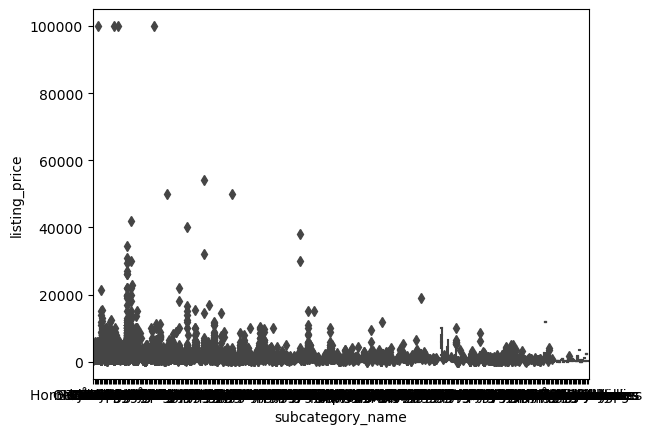

In [40]:
sns.boxplot(x='subcategory_name', y='listing_price', data=df)

### Listings Over Time

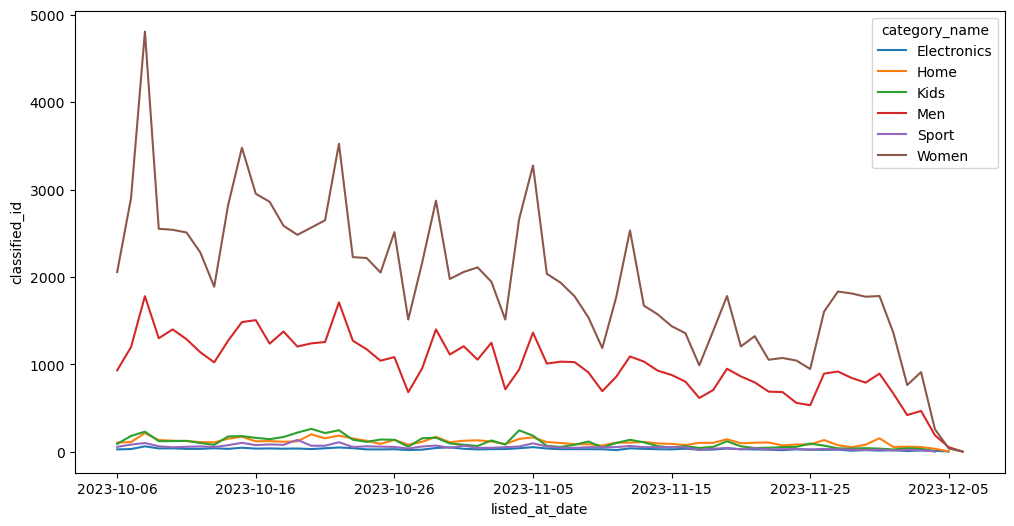

In [27]:
# Figure of listings over time
fig, axs = figure()

data = df.groupby(['listed_at_date', 'category_name']).count()['classified_id'].reset_index().sort_values('listed_at_date')

sns.lineplot(x='listed_at_date', y='classified_id', data=data, ax=axs, hue='category_name')

# Set x-axis ticks to appear every 5th date
axs.set_xticks(axs.get_xticks()[::10])

plt.show()


In [14]:
df.viewed_count.describe(percentiles=[.25, .5, .75, .9, .95, .99])

count    10000.000000
mean        23.342500
std         78.751749
min          2.000000
25%          3.000000
50%          4.000000
75%         17.000000
90%         58.000000
95%         95.000000
99%        249.020000
max       3228.000000
Name: viewed_count, dtype: float64

In [27]:
df.iloc[2179:2180]# , 4].values

,id,created_at,modified_at,user_id,description,price,state,category_id,location_name,size_id,...,brand,condition_id,trendsales_classified_id,retail_price,relisted_classified_id,likes,followers,viewed_count,boosted_at,applied_promotion
2179,25593,2015-01-21 12:56:46,2016-01-30 22:18:54,3,Giant MTB til salg. Kom og se den. Er virkelig...,4000,3,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8,0,3228,1970-01-01 00:00:00,NaN


In [32]:
df.isna().sum() / len(df)

id                          0.0000
created_at                  0.0000
modified_at                 0.0000
user_id                     0.0000
description                 0.1217
price                       0.0000
state                       0.0000
category_id                 0.0000
location_name               0.9885
size_id                     0.8649
color_id                    0.9992
brand                       0.9993
condition_id                0.9975
trendsales_classified_id    1.0000
retail_price                0.9998
relisted_classified_id      1.0000
likes                       0.0000
followers                   0.0000
viewed_count                0.0000
boosted_at                  0.0000
applied_promotion           1.0000
dtype: float64

In [17]:
df.viewed_count.sort_values(ascending=False).head(20)

2179    3228
945     2970
5353    2568
6095    1685
9315    1295
725     1213
774     1083
7116    1064
9138    1023
4902     897
4200     796
3378     796
8181     795
2920     783
1214     717
8558     712
7145     700
3310     668
9663     633
2937     627
Name: viewed_count, dtype: int64